# FIGURE 1

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)
from msresist.pre_processing import preprocessing, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, CorrCoefFilter, TripsMeanAndStd, FilterByStdev, MergeDfbyMean
from msresist.sequence_analysis import pYmotifs, FormatName, FormatSeq
import warnings
warnings.simplefilter("ignore")

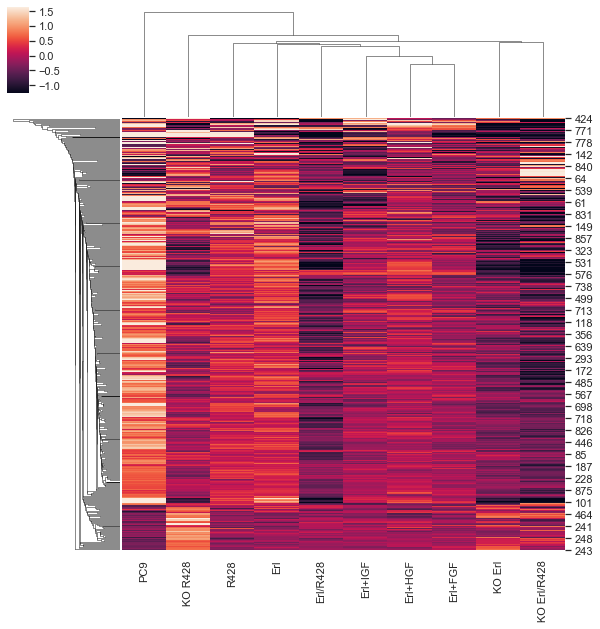

In [2]:
ABC_mc = preprocessing(motifs=True, FCfilter=True, log2T=True)

sns.clustermap(ABC_mc.iloc[:, 2:], method = "single", robust=True)

### 2.3 Phosphorylation Status of Bypass RTKs

Look at the fold-change of canonical phosphorylation sites of bypass RTKs across conditions:

In [3]:
ABC = preprocessing(motifs=False, FCfilter=False, log2T=False)
header = ABC.columns

EGFR = ABC[ABC["peptide-phosphosite"].str.contains("SHQISLDNPDyQQDFFP")].mean()
IGFR = ABC[ABC["peptide-phosphosite"].str.contains("IYETDYyR")].iloc[:, 2:].mean()
MET = ABC[ABC["peptide-phosphosite"].str.contains("MYDkEyYSVHNk")].iloc[:, 2:].mean()
AXL = ABC[ABC["peptide-phosphosite"].str.contains("YNGDyYR")].iloc[:, 2:].mean()

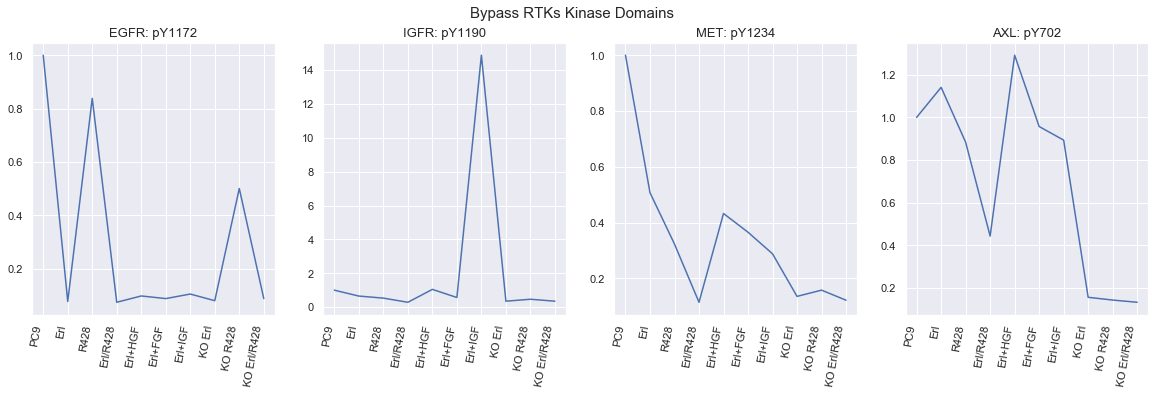

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_title("EGFR: pY1172", fontsize=13)
axs[0].plot(EGFR)
axs[0].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[1].set_title("IGFR: pY1190", fontsize=13)
axs[1].plot(IGFR)
axs[1].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[2].set_title("MET: pY1234", fontsize=13)
axs[2].plot(MET)
axs[2].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
axs[3].set_title("AXL: pY702", fontsize=13)
axs[3].plot(AXL)
axs[3].set_xticklabels(header[2:], rotation=80, horizontalalignment='right')
fig.suptitle('Bypass RTKs Kinase Domains', fontsize=15);

## 3. Variability across Replicates


Concatenated Raw Data:

In [5]:
ABC = preprocessing(rawdata=True)

In [6]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 620, 2: 246, 3: 128}

In [7]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

### 3.1 Grouping by Raw Sequences:

Duplicates:

In [8]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
# DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

Triplicates:

In [9]:
A_r = ABC.copy()

StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, A_r.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
# Xidx = np.all(Stds.values <= 0.4, axis=1)
# Stds = Stds.iloc[Xidx, :]
Std_mean = Stds.iloc[:, 1:].mean(axis=1)

Mean of Correlation Coefficients:  0.5103506049447075
Mean of Standard Deviations:  0.2511817433788223


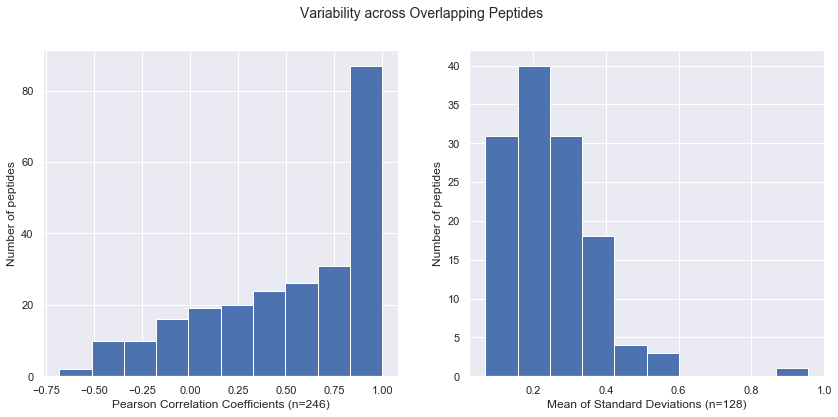

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
n_bins = 10
print("Mean of Correlation Coefficients: ", np.mean(DupsTable_drop.iloc[:, 12]))
print("Mean of Standard Deviations: ", np.mean(Std_mean))
axs[0].hist(DupsTable_drop.iloc[:, 12], bins=n_bins)
axs[0].set_ylabel("Number of peptides", fontsize=12)
axs[0].set_xlabel("Pearson Correlation Coefficients (n=246)", fontsize=12)
axs[1].hist(Std_mean, bins=n_bins)
axs[1].set_xlabel("Mean of Standard Deviations (n=128)", fontsize=12)
axs[1].set_ylabel("Number of peptides", fontsize=12)
fig.suptitle('Variability across Overlapping Peptides', fontsize=14);

### 3.2 Re-implementation grouping by pY-centered motifs:

In [11]:
ABC = preprocessing(rawdata=True)
ABC = pYmotifs(ABC, list(ABC.iloc[:, 1]))

In [12]:
dups = pd.pivot_table(ABC, index=['Master Protein Descriptions', 'peptide-phosphosite'], aggfunc="size").sort_values()
dups_counter = {i: list(dups).count(i) for i in list(dups)}
dups_counter

{1: 509, 2: 229, 3: 110, 4: 22, 5: 10, 6: 9, 7: 1}

In [13]:
NonRecPeptides, CorrCoefPeptides, StdPeptides = MapOverlappingPeptides(ABC)

Duplicates:

In [14]:
DupsTable = BuildMatrix(CorrCoefPeptides, ABC)
# DupsTable = CorrCoefFilter(DupsTable)
DupsTable_drop = DupsTable.drop_duplicates(["peptide-phosphosite", "Master Protein Descriptions"])
assert(DupsTable.shape[0]/2 == DupsTable_drop.shape[0])

Triplicates:

In [15]:
StdPeptides = BuildMatrix(StdPeptides, ABC)
TripsTable = TripsMeanAndStd(StdPeptides, ABC.columns)
Stds = TripsTable.iloc[:, TripsTable.columns.get_level_values(1) == 'std']
# Xidx = np.all(Stds.values <= 0.4, axis=1)
# Stds = Stds.iloc[Xidx, :]
Std_mean = Stds.iloc[:, 1:].mean(axis=1)

Mean of Correlation Coefficients:  0.5115578255168513
Mean of Standard Deviations:  0.2553587144662877


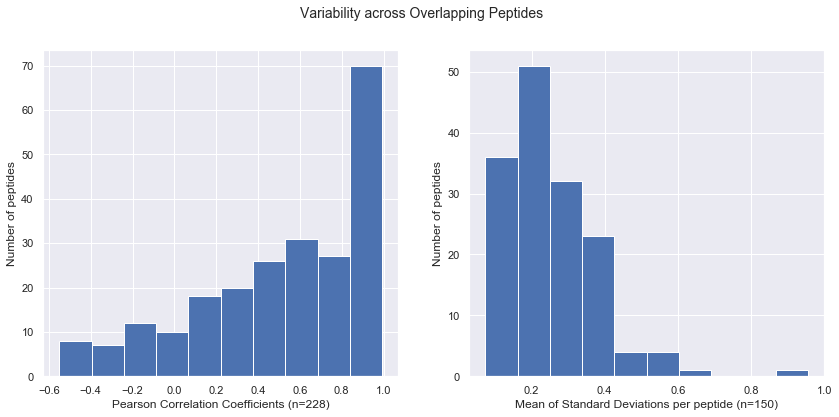

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
n_bins = 10
print("Mean of Correlation Coefficients: ", np.mean(DupsTable_drop.iloc[:, 12]))
print("Mean of Standard Deviations: ", np.mean(Std_mean))
axs[0].hist(DupsTable_drop.iloc[:, 12], bins=n_bins)
axs[0].set_ylabel("Number of peptides", fontsize=12)
axs[0].set_xlabel("Pearson Correlation Coefficients (n=228)", fontsize=12)
axs[1].hist(Std_mean, bins=n_bins)
axs[1].set_xlabel("Mean of Standard Deviations per peptide (n=150)", fontsize=12)
axs[1].set_ylabel("Number of peptides", fontsize=12)
fig.suptitle('Variability across Overlapping Peptides', fontsize=14);